# Assignment 3: Image Classification

**Deadline**: Sunday, May 2nd, by 9pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import glob
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [3]:
main_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/HW3/'

## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.


### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [4]:
# Function fo data loading
def load_data(dir_name): 
  path = main_path + "/data/" + str(dir_name) +"/*.jpg" 
  images = {}
  index = 0;
  for file in glob.glob(path):
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)           # read the image as a numpy array
      images[filename] = img[:, :, :3] # remove the alpha channel

  index_loop = 0
  student_num = 0;
  db = np.zeros((int(len(glob.glob(path))/6), 3, 2, 224, 224, 3))
  for filename, im in sorted (images.items()):
    file_classifiers = (filename[1:-4].split("_"))
    if file_classifiers[2] == 'right':
      file_classifiers[2] = 1
    else:
      file_classifiers[2] = 0
    db[student_num, int(file_classifiers[1]) - 1, int(file_classifiers[2]), :, :, : ] = im/255

    index_loop = index_loop + 1
    if index_loop%6 == 0:
      student_num = student_num + 1
  return db

Import and Save data array as .npy files 

(Run this cell only if you want to save the data as .npy files)

In [ ]:
# Importing the data
#data = load_data("train")
#test_m = load_data("test_m")
#test_w = load_data("test_w")

# Save the data
#path = main_path + '/data/'
#np.save(path_main + '/data.npy', data)
#np.save(path_main + '/test_m.npy', test_m)
#np.save(path_main + '/test_w.npy', test_w)

Load the data

In [5]:
# Load the data
create_new_data_set = 1 # TODO: put 1 if .npy datasets are not avilable

if create_new_data_set == 1:
  data = load_data("train")
  test_m = load_data("test_m")
  test_w = load_data("test_w")
else:
  # Load data array from: My Drive/Intro_to_Deep_Learning/HW3/data/
  path = main_path + "/data/"
  data = np.load(path + '/data.npy')
  test_m = np.load(path + '/test_m.npy')
  test_w = np.load(path + '/test_w.npy')

# use the first 10 elements of `train_xs` as the validation set
train_data, valid_data = data[10:], data[:10]

# Set all value around zeros. Note that it makes the image darker 
train_data = train_data - 0.5
valid_data = valid_data - 0.5
test_m = test_m - 0.5
test_w = test_w - 0.5

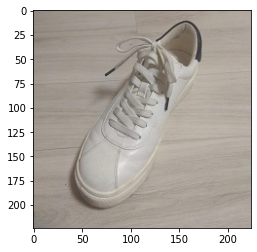

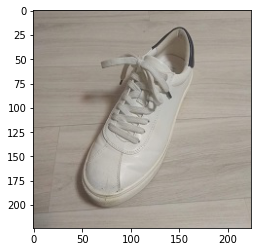

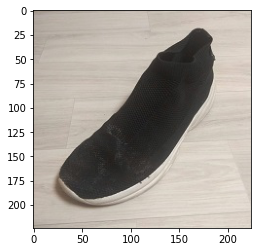

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(103, 3, 2, 224, 224, 3)
(309, 448, 224, 3)


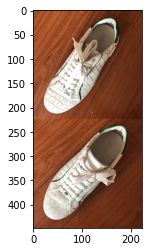

In [7]:
def generate_same_pair(input_data):
  max_stu_idx = input_data.shape[0] # Max index in data
  same_pairs = np.zeros((max_stu_idx*3, 448, 224, 3))
  for stu in range(0,max_stu_idx):
    for pr in range(0,3):
      same_pairs[pr+3*stu,:,:,:] = np.concatenate((input_data[stu,pr,0,:,:,:],
                                                   input_data[stu,pr,1,:,:,:]))
  return same_pairs


# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data+0.5)[0]) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(103, 3, 2, 224, 224, 3)
(309, 448, 224, 3)


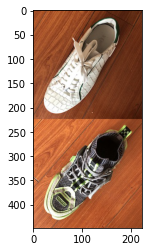

In [8]:
# Randomize Unique array
def randomize_unique_indexes():
  indxs = np.random.permutation(np.arange(3))
  tmp1 = indxs == np.arange(3)
  tmp2 = tmp1[0] or tmp1[1] or tmp1[2]
  while tmp2:
    indxs = np.random.permutation(np.arange(3))
    tmp1 = indxs == np.arange(3)
    tmp2 = tmp1[0] or tmp1[1] or tmp1[2]
  return indxs

def generate_different_pair(input_data):
  max_stu_idx = input_data.shape[0] # Max index in data
  diff_pairs = np.zeros((max_stu_idx*3, 448, 224, 3))
  for stu in range(0,max_stu_idx):
    pairs = randomize_unique_indexes() # Generate Random Indexes for shoes
    for pr in range(0,3):
      diff_pairs[pr+3*stu,:,:,:] = np.concatenate((input_data[stu,pr,0,:,:,:],
                                                   input_data[stu,pairs[pr],1,:,:,:]
                                                   ))
  return diff_pairs


# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data+0.5)[0]) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Answer:**

We insist on different pairs of shoes but from the same person, because the given images are not segmented, and they include the floor as the background.
Given a different backgrounds as input data, may impair the model.
Since the background difference will be also be included, the model will decide if the shoes are matching based on the background and this may create overfit.

Also, every student had the pictures taken from a slightly different angle.
This may case a small mismatch between some shoes, even if they are identical.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Answer:**

Imbalanced data may create overfitting. For the given example of 99% mismatching pairs and 1% matching, the model may be biased on "mismatching" and the result will probably be "mismatching", since the model memorized this result.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [9]:
class CNN(nn.Module):
    def __init__(self, n=4, krn=5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n,
                               kernel_size=krn, padding=int((krn-1)/2))
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n,
                               kernel_size=krn, padding=int((krn-1)/2))
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n,
                               kernel_size=krn, padding=int((krn-1)/2))
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n,
                               kernel_size=krn, padding=int((krn-1)/2))
        self.bnorm1 = nn.BatchNorm2d(8*n)
        self.fc1 = nn.Linear((8*n)*28*14, 100)
        self.bnorm2 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv4(x)
      x = self.bnorm1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = x.view(-1, x.shape[1]*28*14)
      x = self.fc1(x)
      x = self.bnorm2(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x

In [ ]:
from torchsummary import summary
model = CNN(n=4, krn=5) # create untrained model
summary(model, input_size=(3, 224, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 448]             304
            Conv2d-2          [-1, 8, 112, 224]             808
            Conv2d-3          [-1, 16, 56, 112]           3,216
            Conv2d-4           [-1, 32, 28, 56]          12,832
       BatchNorm2d-5           [-1, 32, 28, 56]              64
            Linear-6                  [-1, 100]       1,254,500
       BatchNorm1d-7                  [-1, 100]             200
            Linear-8                    [-1, 2]             202
Total params: 1,272,126
Trainable params: 1,272,126
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.15
Forward/backward pass size (MB): 6.13
Params size (MB): 4.85
Estimated Total Size (MB): 12.13
----------------------------------------------------------------


### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [10]:
class CNNChannel(nn.Module):
    def __init__(self, n=4, krn=5):
        super(CNNChannel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, 
                               kernel_size=krn, padding=int((krn-1)/2))
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, 
                               kernel_size=krn, padding=int((krn-1)/2))
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, 
                               kernel_size=krn, padding=int((krn-1)/2))
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, 
                               kernel_size=krn, padding=int((krn-1)/2))
        self.bnorm1 = nn.BatchNorm2d(8*n)
        self.fc1 = nn.Linear((8*n)*14*14, 100)
        self.bnorm2 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x, n=4): 
      x = torch.cat((x[:,:,:,:224],x[:,:,:,224:]),1)
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv4(x)
      x = self.bnorm1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = x.view(-1, x.shape[1]*14*14)
      x = self.fc1(x)
      x = self.bnorm2(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x

In [ ]:
model = CNNChannel() # create untrained model
summary(model, input_size=(3, 224, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]             604
            Conv2d-2          [-1, 8, 112, 112]             808
            Conv2d-3           [-1, 16, 56, 56]           3,216
            Conv2d-4           [-1, 32, 28, 28]          12,832
       BatchNorm2d-5           [-1, 32, 28, 28]              64
            Linear-6                  [-1, 100]         627,300
       BatchNorm1d-7                  [-1, 100]             200
            Linear-8                    [-1, 2]             202
Total params: 645,226
Trainable params: 645,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.15
Forward/backward pass size (MB): 3.06
Params size (MB): 2.46
Estimated Total Size (MB): 6.67
----------------------------------------------------------------


### Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Answer:**

The first model combines the images into one feature.
The second model, separates every image into an additional feature.
Machine Learning algorithms handles multiple features well and can give less weight to the specific feature if it is less important. If the features are combined into a single feature, the feature extraction of the model may miss the important patterns and avoid prioritising it in the prediction of the next data to come.

### Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Answer:**

We may want to track the susses-rate of the two of the possible labels, the "pairs" and the "not-pairs", to evaluate how well the model handles the data, and notice if the model favors (overfit) specific label.

Additionally, it is enabling the calculation of the False-Positive and False-Negative, therefore, it will enable building a confusion matrix for comfortable representation and evaluation.

In previous assignment, we had many possible labels to complete the sentence, therefore - there is not only one true prediction. The current assignment has more specific target, with two labels only: the pair of the shoes is matching - or not.

In [11]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # shape [n*3,448,224,3]
    data_neg = generate_different_pair(data) # shape [n*3,448,224,3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()


    total_correct = (pos_correct + neg_correct)/(n * 6)


    return pos_correct / (n * 3), neg_correct / (n * 3), total_correct

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [16]:
# Train 1 Epoch
def train_model(model, train_data, validation_data, batch_size, 
                learning_rate, weight_decay):

  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)

  # Generate same and different pairs
  data_pos = generate_same_pair(train_data)
  data_neg = generate_different_pair(train_data)

  # Shuffle at the start of the epoch
  data_pos = data_pos[np.random.permutation(data_pos.shape[0])]
  data_neg = data_neg[np.random.permutation(data_neg.shape[0])]

  batch_size = batch_size//2
  for i in range(0, len(data_pos), batch_size):
    data_batched = np.concatenate((data_pos[i:i+batch_size],
                                  data_neg[i:i+batch_size]),0)

    xs = torch.Tensor(data_batched).transpose(1, 3)

    # Create labels
    st = torch.cat((torch.ones(xs.shape[0]//2),torch.zeros(xs.shape[0]//2)),0)
    st = st.type(torch.long)

    # Traning
    zs = model(xs)
    loss = criterion(zs, st) # compute the total loss
    loss.backward() # compute updates for each parameter
    optimizer.step() # make the updates for each parameter
    optimizer.zero_grad() # a clean up step for PyTorch

  avg_loss = float(loss)/(batch_size*2)  # compute *average* loss

  pos_acc_trn, neg_acc_trn, acc_trn= get_accuracy(model, train_data, batch_size)
  pos_acc_val, neg_acc_val, acc_val= get_accuracy(model, validation_data, batch_size)
  return pos_acc_val, neg_acc_val, pos_acc_trn, neg_acc_trn, acc_trn, acc_val, avg_loss


# Function for plotting the results of train_model()
def plot_the_results_fun(epoch,avg_loss, acc_trn, acc_val, 
                         pos_acc_trn, neg_acc_trn, pos_acc_val, neg_acc_val,
                         loss_curve=1, total_acc_curve=1, pos_neg_acc_curve=1,
                         valid_curves=1): 
  if loss_curve==1:
    plt.title("Learning Curve: Loss per Epoch")
    plt.plot(range(0,epoch), avg_loss, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

  if total_acc_curve ==1:
    plt.title("Learning Curve: Accuracy per Epoch")
    plt.plot(range(0,epoch), acc_trn, label="Train")
    if valid_curves ==1:
      plt.plot(range(0,epoch), acc_val, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

  if pos_neg_acc_curve==1:
    if valid_curves ==1:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    else:
      fig, (ax1) = plt.subplots(1, 1)

    fig.suptitle('Learning Curve: Positive and Negative Accuracy per Epoch')
    ax1.set_title("Train")
    ax1.plot(range(0,epoch), pos_acc_trn, 'g--', label="Positive")
    ax1.plot(range(0,epoch), neg_acc_trn, 'r--', label="Negative")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='best')

    if valid_curves ==1:
      ax2.set_title("Validation")
      ax2.plot(range(0,epoch), pos_acc_val, 'g', label="Positive")
      ax2.plot(range(0,epoch), neg_acc_val, 'r', label="Negative")
      ax2.set_xlabel("Epochs")
      ax2.legend(loc='best')


# Full model Traning
def run_model_training(max_epoch, n, krn, td, vd, batch_size, learning_rate, 
                       weight_decay, mdl='CNN', 
                       sanity=False, save_model = False):

  # init lists
  lis_pos_acc_val, lis_neg_acc_val, lis_pos_acc_trn,  = [], [], []
  lis_neg_acc_trn, lis_acc_trn, lis_acc_val, lis_avg_loss = [], [], [], []

  # Choose Model
  if mdl == 'CNN':
    model = CNN(n, krn) 
  elif mdl =='CNNChannel':
    model = CNNChannel(n, krn)

  # Model name for save purpose
  if save_model:
    name = mdl
    if sanity:
      name = mdl + '_sanity_check'
    checkpoint_path= main_path + '/models/' + str(name) + '/epoch-{}.pk' 

  # Train the model
  print("Traning...")
  for epoch in range(0, max_epoch):
    learning_curve_info = train_model(model, 
                                        td, 
                                        vd, 
                                        batch_size, 
                                        learning_rate, 
                                        weight_decay)
    
  # Save results in tuple (for ploting)
    lis_pos_acc_val.append(learning_curve_info[0])
    lis_neg_acc_val.append(learning_curve_info[1])
    lis_pos_acc_trn.append(learning_curve_info[2])
    lis_neg_acc_trn.append(learning_curve_info[3])
    lis_acc_trn.append(learning_curve_info[4])
    lis_acc_val.append(learning_curve_info[5])
    lis_avg_loss.append(learning_curve_info[6])

    if sanity:
      print("Epoch %d, Train: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%% | Loss %f]" % (
      epoch, 
      learning_curve_info[4] * 100, learning_curve_info[2]* 100, #Train: Total, Pos
      learning_curve_info[3] * 100, learning_curve_info[6])) #Train: neg, loss
    else:
      print("Epoch %d, Val: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]\
 Train: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%% | Loss %f]" % (
      epoch, 
      learning_curve_info[5] * 100, learning_curve_info[0] * 100, #Val: Total, Pos
      learning_curve_info[1] * 100, #Val: Neg
      learning_curve_info[4] * 100, learning_curve_info[2]* 100, #Train: Total, Pos
      learning_curve_info[3] * 100, learning_curve_info[6])) #Train: neg, loss
      
    # Save model
    if save_model:
      torch.save(model.state_dict(), checkpoint_path.format(epoch))

  if sanity:
    vc = 0;
  else:
    vc = 1;

  # Plot the learning curves
  print("Plotting...")
  plot_the_results_fun(epoch = max_epoch,
                      avg_loss = lis_avg_loss,
                      acc_trn = lis_acc_trn,
                      acc_val = lis_acc_val,
                      pos_acc_trn = lis_pos_acc_trn,
                      neg_acc_trn = lis_neg_acc_trn,
                      pos_acc_val = lis_pos_acc_val,
                      neg_acc_val = lis_neg_acc_val,
                      valid_curves = vc)

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

Traning...
Epoch 0, Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.058777]
Epoch 1, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.074818]
Epoch 2, Train: [Acc 58% | Pos 100% | Neg 17% | Loss 0.054647]
Epoch 3, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.050154]
Epoch 4, Train: [Acc 75% | Pos 100% | Neg 50% | Loss 0.041113]
Epoch 5, Train: [Acc 67% | Pos 33% | Neg 100% | Loss 0.032786]
Epoch 6, Train: [Acc 83% | Pos 100% | Neg 67% | Loss 0.040236]
Epoch 7, Train: [Acc 75% | Pos 83% | Neg 67% | Loss 0.032086]
Epoch 8, Train: [Acc 83% | Pos 83% | Neg 83% | Loss 0.028976]
Epoch 9, Train: [Acc 58% | Pos 50% | Neg 67% | Loss 0.032348]
Epoch 10, Train: [Acc 75% | Pos 100% | Neg 50% | Loss 0.034458]
Epoch 11, Train: [Acc 58% | Pos 100% | Neg 17% | Loss 0.020064]
Epoch 12, Train: [Acc 67% | Pos 33% | Neg 100% | Loss 0.049207]
Epoch 13, Train: [Acc 75% | Pos 67% | Neg 83% | Loss 0.025794]
Epoch 14, Train: [Acc 75% | Pos 67% | Neg 83% | Loss 0.025723]
Epoch 15, Train: [Acc 58% | Pos 33% | Neg 83% |

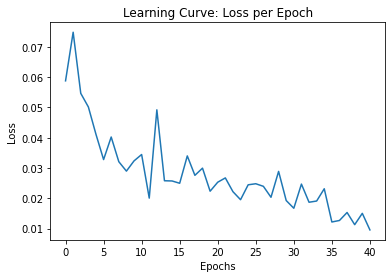

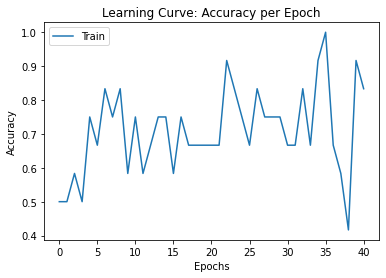

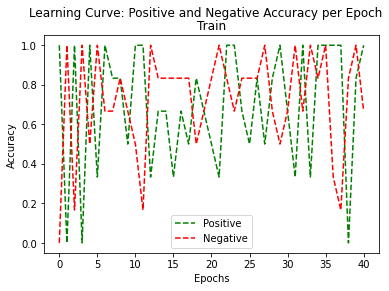

In [ ]:
# Sanity Check for CNN model
run_model_training(max_epoch = 41,
                  n = 10,
                  krn = 5,
                  td = train_data[:2],
                  vd = valid_data[:2],
                  batch_size = 12,
                  learning_rate = 0.005,
                  weight_decay = 1e-9,
                  mdl = 'CNN',
                  sanity = True,
                  save_model = False)

In [19]:
# Load model of sanity check (CNN):
pth_mdl = main_path + '/models/'
model = CNN(n=10, krn=5) 
model.load_state_dict(torch.load(pth_mdl+'/CNN_sanity_check/epoch-35.pk'))

pos_acc_trn, neg_acc_trn, acc_trn= get_accuracy(model, train_data[:2], batch_size=12)

print("Train: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc_trn * 100, pos_acc_trn * 100, neg_acc_trn * 100))

Train: [Acc 100% | Pos 100% | Neg 100%]


Traning...
Epoch 0, Train: [Acc 42% | Pos 67% | Neg 17% | Loss 0.063459]
Epoch 1, Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.059896]
Epoch 2, Train: [Acc 67% | Pos 33% | Neg 100% | Loss 0.055179]
Epoch 3, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.053673]
Epoch 4, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.035517]
Epoch 5, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.062204]
Epoch 6, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.045764]
Epoch 7, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.027323]
Epoch 8, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.043103]
Epoch 9, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.019204]
Epoch 10, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.028444]
Epoch 11, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.018607]
Epoch 12, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.028936]
Epoch 13, Train: [Acc 58% | Pos 17% | Neg 100% | Loss 0.013993]
Epoch 14, Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.011340]
Epoch 15, Train: [Acc 50% | Pos 0% | Neg 100% | Loss

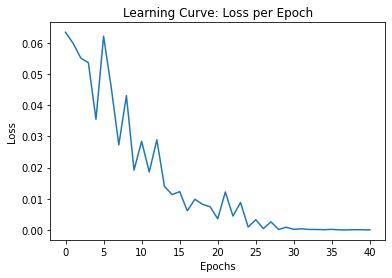

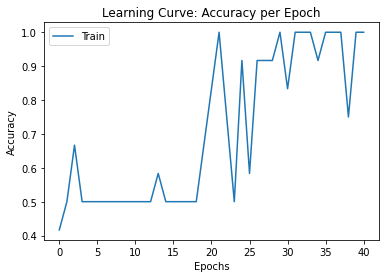

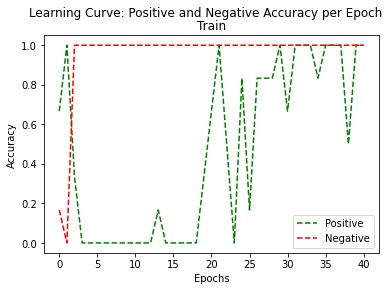

In [ ]:
# Sanity Check for CNNChannel model
run_model_training(max_epoch = 41,
                  n = 10,
                  krn = 5,
                  td = train_data[:2],
                  vd = valid_data[:2],
                  batch_size = 12,
                  learning_rate = 0.005,
                  weight_decay = 1e-9,
                  mdl = 'CNNChannel',
                  sanity = True,
                  save_model = False)

In [ ]:
# Load model of sanity check (CNNChannel):
pth_mdl = main_path + '/models/'
model = CNNChannel(n=10, krn=5) 
model.load_state_dict(torch.load(pth_mdl+'/CNNChannel_sanity_check/epoch-40.pk'))

pos_acc_trn, neg_acc_trn, acc_trn= get_accuracy(model, train_data[:2], batch_size=12)

print("Train: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc_trn * 100, pos_acc_trn * 100, neg_acc_trn * 100))

Train: [Acc 100% | Pos 100% | Neg 100%]


### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Answer:**

Each one of the hyperparameters has a different role and effect on the training process of the model:

* batch size - as we learned in class and saw in past exercises large batch size case the loss per epoch graph be more stable. However, the tarin time is increases.
We decided to set this value as 50 because we did not see drastic changes in higher values. And for lower values the accuracy of the model was worse.

* Learning rate – high values can case the model skip the minimum, and low value can cause to a very long convergence. Additionally, by using low value the is a chance to stuck in local minimum.

* Weight decay – provides an approach to reduce the overfitting of a deep learning neural network model on the training data and improve the performance of the model on new data. We need to choose low values so the impact on the loss function won't be to big – is cand cause wrong update to the weights and biases.

* Kernel size – One of the reasons we prefer small kernel is that it reduces computational costs and weight sharing that ultimately leads to lesser weights for back-propagation. Large kernel value cause extremely longer training time.
We chose odd-sized filter - because odd-sized filters symmetrically divide the previous layer pixels around the output pixel. And if this symmetry is not present, there will be distortions across the layers which happens when using an even sized kernels.



###CNN

Standard hyperparameter

Traning...
Epoch 0, Val: [Acc 52% | Pos 100% | Neg 3%] Train: [Acc 50% | Pos 99% | Neg 1% | Loss 0.013820]
Epoch 1, Val: [Acc 48% | Pos 40% | Neg 57%] Train: [Acc 50% | Pos 54% | Neg 46% | Loss 0.014361]
Epoch 2, Val: [Acc 58% | Pos 73% | Neg 43%] Train: [Acc 60% | Pos 93% | Neg 26% | Loss 0.013298]
Epoch 3, Val: [Acc 60% | Pos 60% | Neg 60%] Train: [Acc 59% | Pos 44% | Neg 75% | Loss 0.012132]
Epoch 4, Val: [Acc 63% | Pos 53% | Neg 73%] Train: [Acc 65% | Pos 51% | Neg 78% | Loss 0.011538]
Epoch 5, Val: [Acc 72% | Pos 90% | Neg 53%] Train: [Acc 75% | Pos 93% | Neg 58% | Loss 0.012131]
Epoch 6, Val: [Acc 80% | Pos 70% | Neg 90%] Train: [Acc 70% | Pos 54% | Neg 85% | Loss 0.010807]
Epoch 7, Val: [Acc 67% | Pos 77% | Neg 57%] Train: [Acc 75% | Pos 87% | Neg 62% | Loss 0.012042]
Epoch 8, Val: [Acc 83% | Pos 93% | Neg 73%] Train: [Acc 77% | Pos 89% | Neg 65% | Loss 0.010029]
Epoch 9, Val: [Acc 73% | Pos 80% | Neg 67%] Train: [Acc 79% | Pos 94% | Neg 64% | Loss 0.008502]
Epoch 10, Val: [Acc 

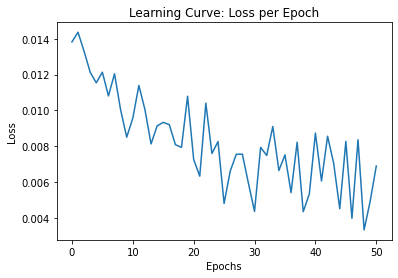

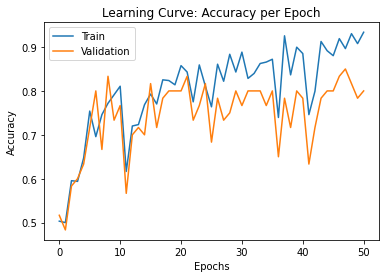

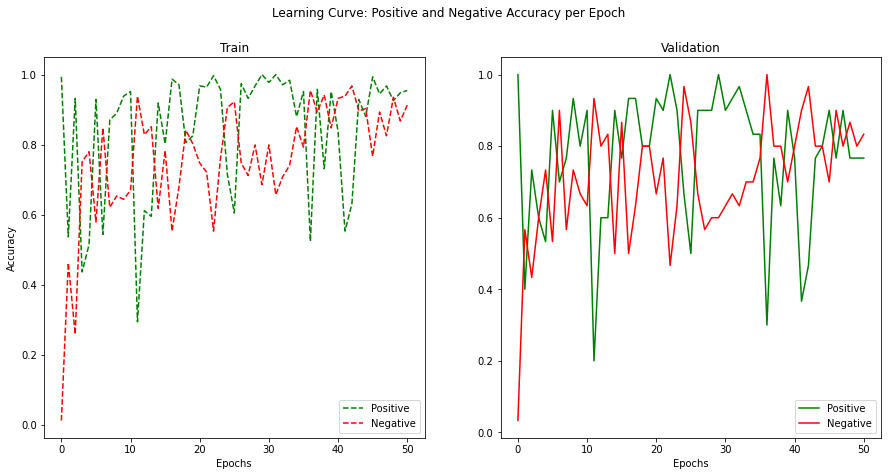

In [ ]:
### standard hyperparameter
run_model_training(max_epoch = 51,
                  n = 4,
                  krn = 5,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.005,
                  weight_decay = 1e-9,
                  mdl = 'CNN',
                  save_model = False)

Hyperparameter change: batch_size HIGH = 100

Traning...
Epoch 0, Val: [Acc 50% | Pos 0% | Neg 100%] Train: [Acc 50% | Pos 4% | Neg 96% | Loss 0.007699]
Epoch 1, Val: [Acc 48% | Pos 10% | Neg 87%] Train: [Acc 51% | Pos 10% | Neg 92% | Loss 0.006813]
Epoch 2, Val: [Acc 65% | Pos 97% | Neg 33%] Train: [Acc 67% | Pos 85% | Neg 49% | Loss 0.006711]
Epoch 3, Val: [Acc 55% | Pos 97% | Neg 13%] Train: [Acc 51% | Pos 97% | Neg 6% | Loss 0.006659]
Epoch 4, Val: [Acc 67% | Pos 70% | Neg 63%] Train: [Acc 72% | Pos 79% | Neg 65% | Loss 0.005757]
Epoch 5, Val: [Acc 65% | Pos 57% | Neg 73%] Train: [Acc 71% | Pos 63% | Neg 78% | Loss 0.005356]
Epoch 6, Val: [Acc 70% | Pos 57% | Neg 83%] Train: [Acc 71% | Pos 66% | Neg 77% | Loss 0.004887]
Epoch 7, Val: [Acc 83% | Pos 80% | Neg 87%] Train: [Acc 80% | Pos 85% | Neg 75% | Loss 0.004566]
Epoch 8, Val: [Acc 58% | Pos 30% | Neg 87%] Train: [Acc 64% | Pos 36% | Neg 92% | Loss 0.005551]
Epoch 9, Val: [Acc 65% | Pos 50% | Neg 80%] Train: [Acc 71% | Pos 56% | Neg 85% | Loss 0.005591]
Epoch 10, Val: [Acc 6

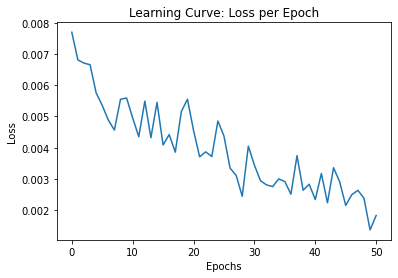

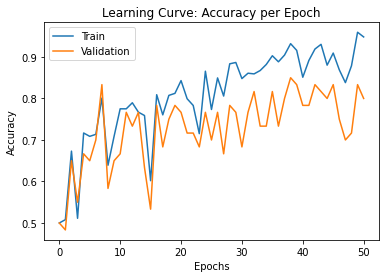

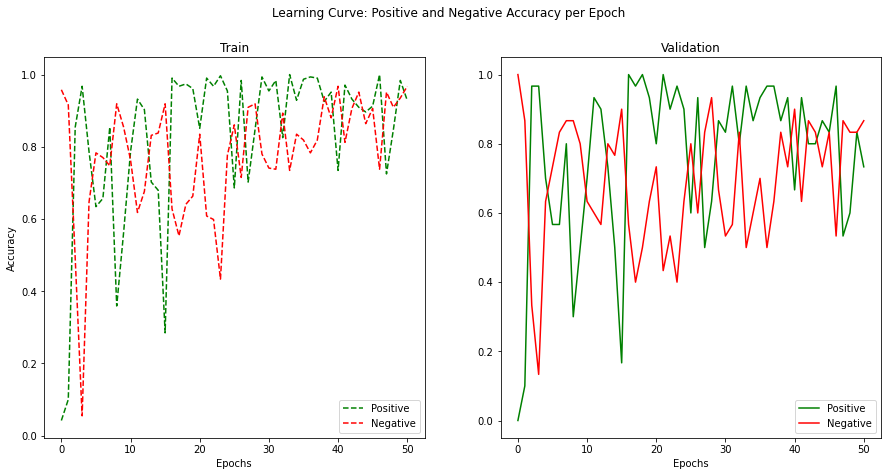

In [ ]:
### hyperparameter change: batch_size HIGH = 100
run_model_training(max_epoch = 51,
                  n = 4,
                  krn = 5,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 100,
                  learning_rate = 0.005,
                  weight_decay = 1e-9,
                  mdl = 'CNN',
                  save_model = False)

Hyperparameter change: learning_rate LOW = 0.001

Traning...
Epoch 0, Val: [Acc 50% | Pos 0% | Neg 100%] Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.013760]
Epoch 1, Val: [Acc 50% | Pos 0% | Neg 100%] Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.013498]
Epoch 2, Val: [Acc 50% | Pos 0% | Neg 100%] Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.013255]
Epoch 3, Val: [Acc 55% | Pos 23% | Neg 87%] Train: [Acc 56% | Pos 21% | Neg 90% | Loss 0.011394]
Epoch 4, Val: [Acc 68% | Pos 100% | Neg 37%] Train: [Acc 72% | Pos 99% | Neg 45% | Loss 0.010826]
Epoch 5, Val: [Acc 77% | Pos 80% | Neg 73%] Train: [Acc 76% | Pos 89% | Neg 62% | Loss 0.009747]
Epoch 6, Val: [Acc 65% | Pos 73% | Neg 57%] Train: [Acc 68% | Pos 66% | Neg 71% | Loss 0.010765]
Epoch 7, Val: [Acc 63% | Pos 97% | Neg 30%] Train: [Acc 68% | Pos 98% | Neg 39% | Loss 0.010038]
Epoch 8, Val: [Acc 77% | Pos 97% | Neg 57%] Train: [Acc 77% | Pos 94% | Neg 61% | Loss 0.010774]
Epoch 9, Val: [Acc 67% | Pos 67% | Neg 67%] Train: [Acc 74% | Pos 75% | Neg 73% | Loss 0.007949]
Epoch 10, Val: [Ac

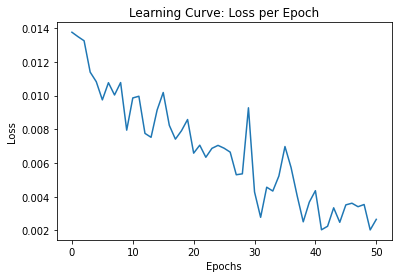

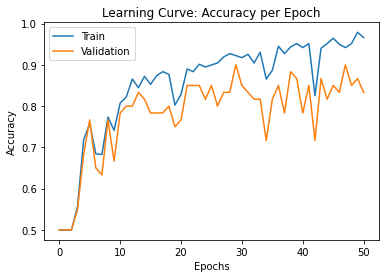

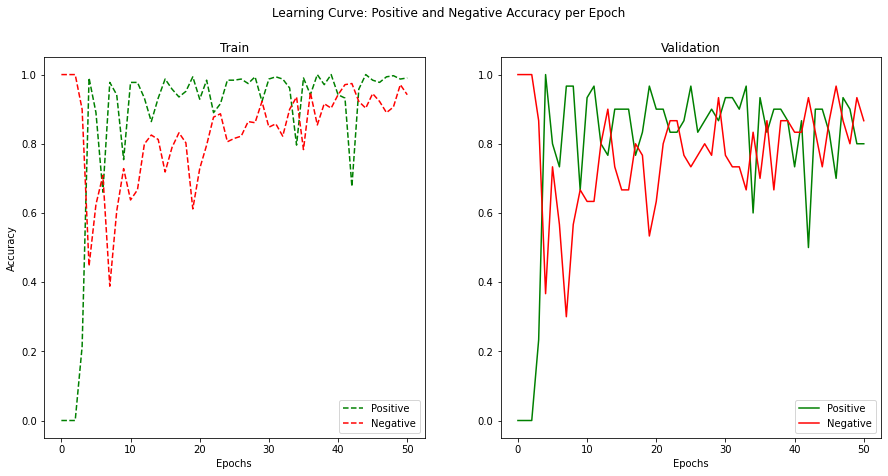

In [ ]:
### hyperparameter change: learning_rate LOW = 0.001
run_model_training(max_epoch = 51,
                  n = 4,
                  krn = 5,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.001,
                  weight_decay = 1e-9,
                  mdl = 'CNN',
                  save_model = False)

Hyperparameter change: weight_decay HIGH = 1e-6

Traning...
Epoch 0, Val: [Acc 53% | Pos 47% | Neg 60%] Train: [Acc 55% | Pos 71% | Neg 39% | Loss 0.015088]
Epoch 1, Val: [Acc 55% | Pos 67% | Neg 43%] Train: [Acc 59% | Pos 90% | Neg 27% | Loss 0.013248]
Epoch 2, Val: [Acc 63% | Pos 53% | Neg 73%] Train: [Acc 61% | Pos 39% | Neg 83% | Loss 0.013426]
Epoch 3, Val: [Acc 65% | Pos 90% | Neg 40%] Train: [Acc 72% | Pos 88% | Neg 55% | Loss 0.013646]
Epoch 4, Val: [Acc 67% | Pos 93% | Neg 40%] Train: [Acc 68% | Pos 81% | Neg 55% | Loss 0.011244]
Epoch 5, Val: [Acc 67% | Pos 97% | Neg 37%] Train: [Acc 73% | Pos 96% | Neg 50% | Loss 0.010084]
Epoch 6, Val: [Acc 78% | Pos 100% | Neg 57%] Train: [Acc 71% | Pos 97% | Neg 45% | Loss 0.010617]
Epoch 7, Val: [Acc 78% | Pos 97% | Neg 60%] Train: [Acc 78% | Pos 97% | Neg 60% | Loss 0.010733]
Epoch 8, Val: [Acc 57% | Pos 97% | Neg 17%] Train: [Acc 58% | Pos 97% | Neg 18% | Loss 0.009685]
Epoch 9, Val: [Acc 73% | Pos 53% | Neg 93%] Train: [Acc 74% | Pos 66% | Neg 82% | Loss 0.010840]
Epoch 10, Val: [Ac

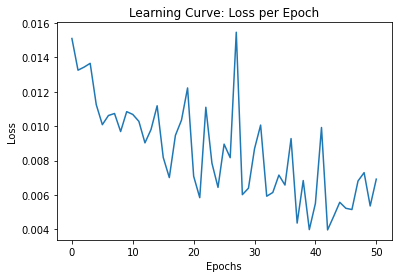

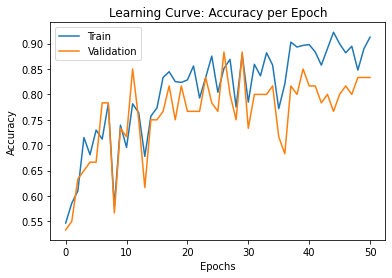

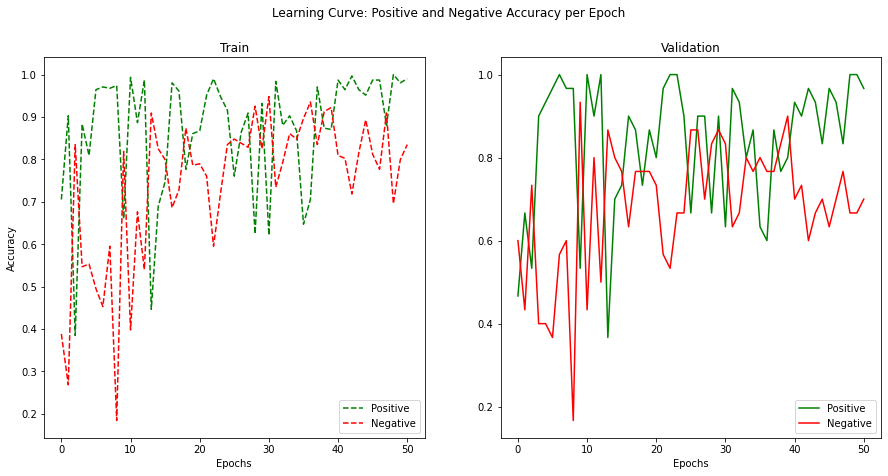

In [ ]:
### hyperparameter change: weight_decay HIGH = 1e-6
run_model_training(max_epoch = 51,
                  n = 4,
                  krn = 5,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.005,
                  weight_decay = 1e-6,
                  mdl = 'CNN',
                  save_model = False)

Hyperparameter change: kernal size and n to HIGH = 7, 10

Traning...
Epoch 0, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 99% | Neg 0% | Loss 0.014732]
Epoch 1, Val: [Acc 57% | Pos 93% | Neg 20%] Train: [Acc 56% | Pos 92% | Neg 19% | Loss 0.014696]
Epoch 2, Val: [Acc 70% | Pos 67% | Neg 73%] Train: [Acc 68% | Pos 69% | Neg 67% | Loss 0.011590]
Epoch 3, Val: [Acc 62% | Pos 33% | Neg 90%] Train: [Acc 62% | Pos 33% | Neg 91% | Loss 0.011005]
Epoch 4, Val: [Acc 68% | Pos 97% | Neg 40%] Train: [Acc 73% | Pos 89% | Neg 56% | Loss 0.011924]
Epoch 5, Val: [Acc 77% | Pos 100% | Neg 53%] Train: [Acc 76% | Pos 95% | Neg 57% | Loss 0.009155]
Epoch 6, Val: [Acc 58% | Pos 20% | Neg 97%] Train: [Acc 63% | Pos 30% | Neg 95% | Loss 0.009880]
Epoch 7, Val: [Acc 70% | Pos 67% | Neg 73%] Train: [Acc 78% | Pos 83% | Neg 74% | Loss 0.012557]
Epoch 8, Val: [Acc 83% | Pos 83% | Neg 83%] Train: [Acc 78% | Pos 84% | Neg 72% | Loss 0.008538]
Epoch 9, Val: [Acc 78% | Pos 87% | Neg 70%] Train: [Acc 78% | Pos 93% | Neg 63% | Loss 0.008590]
Epoch 10, Val: [Acc

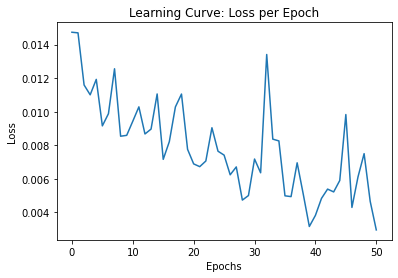

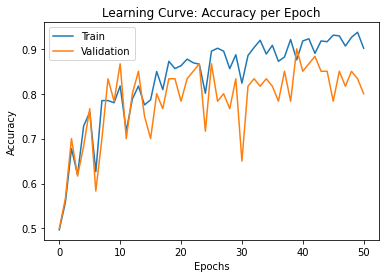

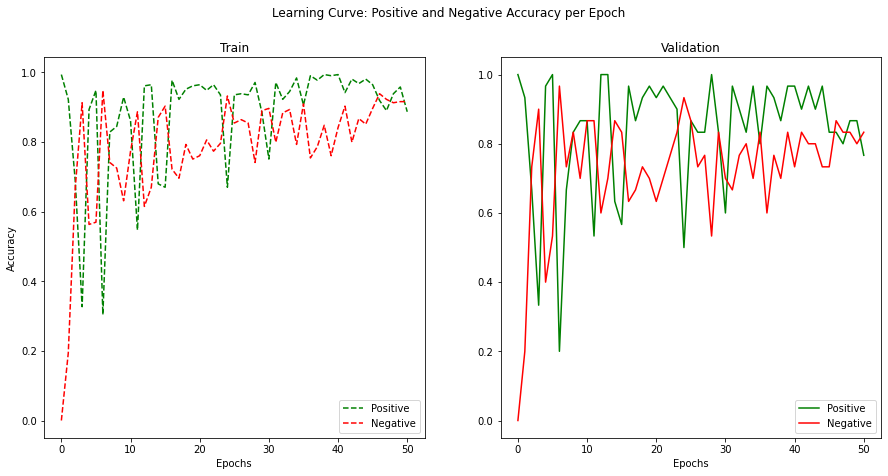

In [ ]:
### hyperparameter change: kernal size and n to HIGH = 7, 10
run_model_training(max_epoch = 51,
                  n = 10,
                  krn = 7,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.005,
                  weight_decay = 1e-9,
                  mdl = 'CNN',
                  save_model = False)

Final Model

Traning...
Epoch 0, Val: [Acc 53% | Pos 33% | Neg 73%] Train: [Acc 50% | Pos 20% | Neg 79% | Loss 0.029518]
Epoch 1, Val: [Acc 57% | Pos 93% | Neg 20%] Train: [Acc 54% | Pos 65% | Neg 42% | Loss 0.029177]
Epoch 2, Val: [Acc 58% | Pos 77% | Neg 40%] Train: [Acc 60% | Pos 61% | Neg 59% | Loss 0.029353]
Epoch 3, Val: [Acc 62% | Pos 97% | Neg 27%] Train: [Acc 65% | Pos 75% | Neg 56% | Loss 0.025493]
Epoch 4, Val: [Acc 62% | Pos 90% | Neg 33%] Train: [Acc 69% | Pos 76% | Neg 63% | Loss 0.024840]
Epoch 5, Val: [Acc 58% | Pos 93% | Neg 23%] Train: [Acc 59% | Pos 96% | Neg 21% | Loss 0.024079]
Epoch 6, Val: [Acc 63% | Pos 87% | Neg 40%] Train: [Acc 72% | Pos 87% | Neg 57% | Loss 0.024351]
Epoch 7, Val: [Acc 63% | Pos 63% | Neg 63%] Train: [Acc 67% | Pos 59% | Neg 76% | Loss 0.018278]
Epoch 8, Val: [Acc 73% | Pos 87% | Neg 60%] Train: [Acc 75% | Pos 87% | Neg 62% | Loss 0.029607]
Epoch 9, Val: [Acc 75% | Pos 90% | Neg 60%] Train: [Acc 77% | Pos 90% | Neg 64% | Loss 0.020881]
Epoch 10, Val: [Acc

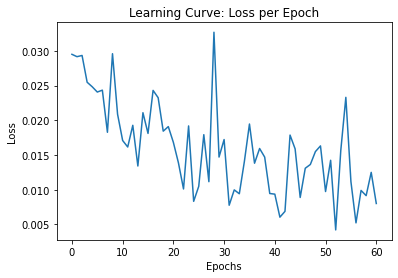

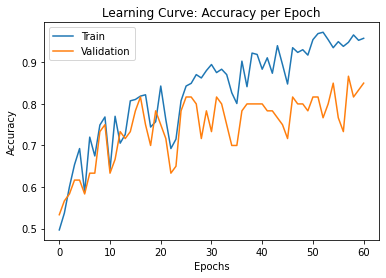

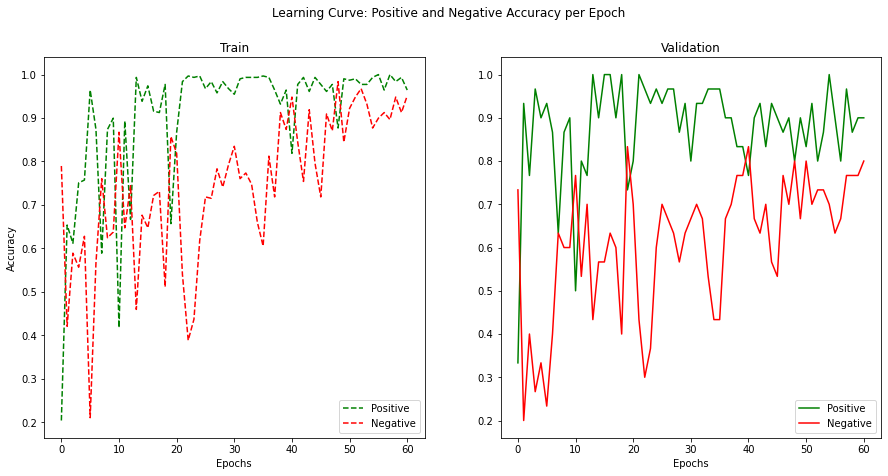

In [ ]:
### Final Model
run_model_training(max_epoch = 61,
                  n = 6,
                  krn = 7,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.001,
                  weight_decay = 1e-9,
                  mdl = 'CNN',
                  save_model = False)

###CNNChannel

Standard hyperparameter

Traning...
Epoch 0, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.014470]
Epoch 1, Val: [Acc 57% | Pos 100% | Neg 13%] Train: [Acc 57% | Pos 100% | Neg 14% | Loss 0.009760]
Epoch 2, Val: [Acc 50% | Pos 0% | Neg 100%] Train: [Acc 52% | Pos 4% | Neg 100% | Loss 0.009093]
Epoch 3, Val: [Acc 72% | Pos 93% | Neg 50%] Train: [Acc 84% | Pos 91% | Neg 76% | Loss 0.007080]
Epoch 4, Val: [Acc 68% | Pos 100% | Neg 37%] Train: [Acc 78% | Pos 97% | Neg 60% | Loss 0.006047]
Epoch 5, Val: [Acc 77% | Pos 97% | Neg 57%] Train: [Acc 82% | Pos 97% | Neg 67% | Loss 0.006399]
Epoch 6, Val: [Acc 83% | Pos 97% | Neg 70%] Train: [Acc 83% | Pos 97% | Neg 68% | Loss 0.004629]
Epoch 7, Val: [Acc 83% | Pos 93% | Neg 73%] Train: [Acc 89% | Pos 98% | Neg 79% | Loss 0.004732]
Epoch 8, Val: [Acc 82% | Pos 90% | Neg 73%] Train: [Acc 92% | Pos 94% | Neg 91% | Loss 0.004221]
Epoch 9, Val: [Acc 72% | Pos 50% | Neg 93%] Train: [Acc 78% | Pos 57% | Neg 98% | Loss 0.003617]
Epoch 10, Val: [

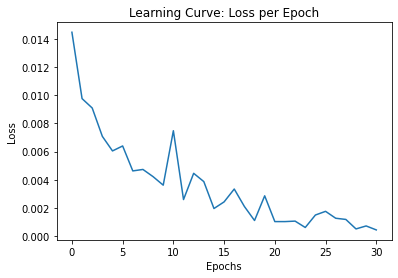

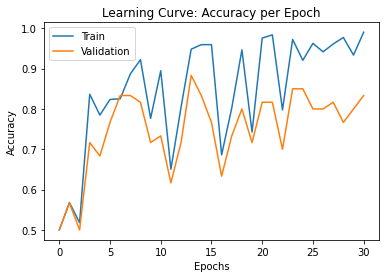

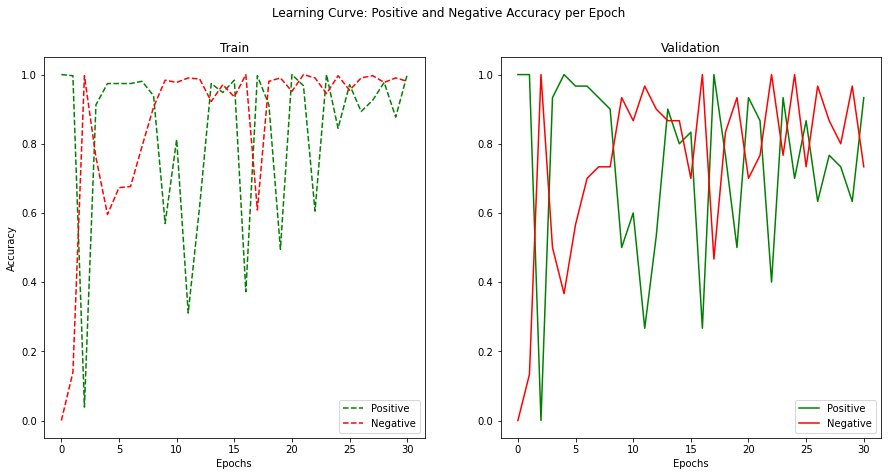

In [ ]:
### standard hyperparameter
run_model_training(max_epoch = 31,
                    n = 6,
                    krn = 3,
                    td = train_data,
                    vd = valid_data,
                    batch_size = 50,
                    learning_rate = 0.001,
                    weight_decay = 1e-9,
                    mdl = 'CNNChannel',
                    save_model = False)

Hyperparameter change: batch_size HIGH = 200

Traning...
Epoch 0, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.003827]
Epoch 1, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.002809]
Epoch 2, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.002352]
Epoch 3, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.002077]
Epoch 4, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.001774]
Epoch 5, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.001531]
Epoch 6, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.001720]
Epoch 7, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.001580]
Epoch 8, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.001436]
Epoch 9, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.001192]
Epoch 10, Val: [Acc

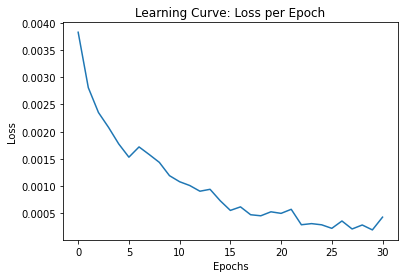

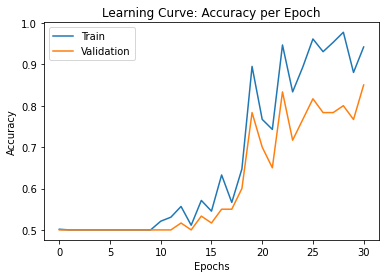

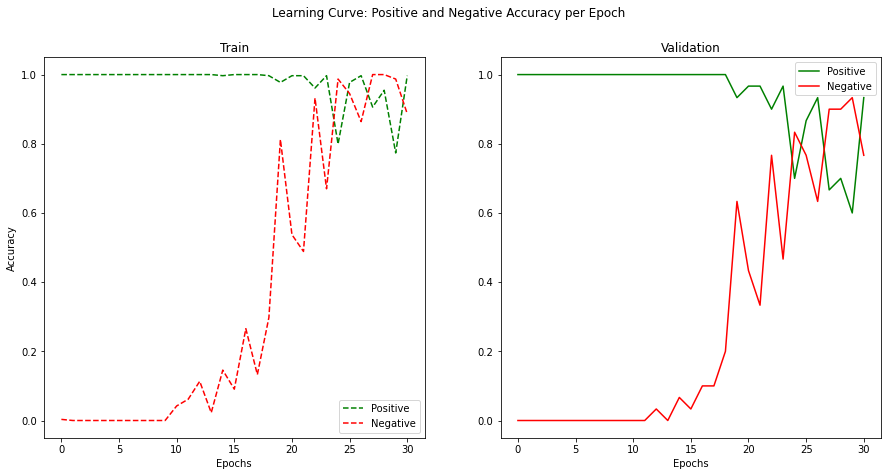

In [ ]:
### hyperparameter change: batch_size HIGH = 200
run_model_training(max_epoch = 31,
                    n = 6,
                    krn = 3,
                    td = train_data,
                    vd = valid_data,
                    batch_size = 200,
                    learning_rate = 0.001,
                    weight_decay = 1e-9,
                    mdl = 'CNNChannel',
                    save_model = False)

Hyperparameter change: learning_rate LOW = 0.0001

Traning...
Epoch 0, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.015323]
Epoch 1, Val: [Acc 50% | Pos 0% | Neg 100%] Train: [Acc 50% | Pos 0% | Neg 100% | Loss 0.015635]
Epoch 2, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.012004]
Epoch 3, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.012834]
Epoch 4, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.010493]
Epoch 5, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 52% | Pos 100% | Neg 4% | Loss 0.011524]
Epoch 6, Val: [Acc 68% | Pos 70% | Neg 67%] Train: [Acc 80% | Pos 93% | Neg 68% | Loss 0.009658]
Epoch 7, Val: [Acc 72% | Pos 80% | Neg 63%] Train: [Acc 84% | Pos 96% | Neg 72% | Loss 0.009568]
Epoch 8, Val: [Acc 63% | Pos 30% | Neg 97%] Train: [Acc 76% | Pos 56% | Neg 96% | Loss 0.008572]
Epoch 9, Val: [Acc 63% | Pos 83% | Neg 43%] Train: [Acc 81% | Pos 99% | Neg 64% | Loss 0.007327]
Epoch 10, Val: [Acc

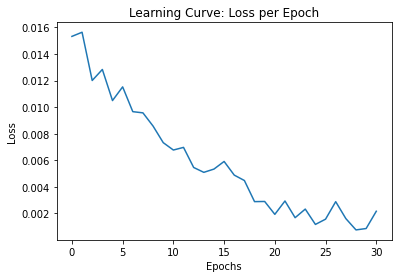

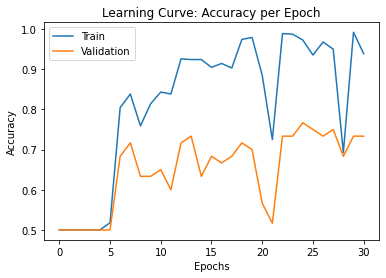

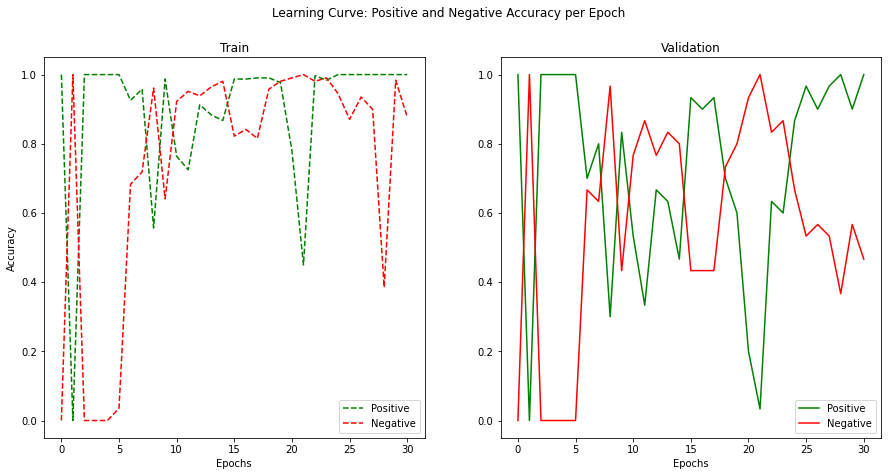

In [ ]:
### hyperparameter change: learning_rate LOW = 0.0001
run_model_training(max_epoch = 31,
                  n = 6,
                  krn = 3,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.0001,
                  weight_decay = 1e-9,
                  mdl = 'CNNChannel',
                  save_model = False)

Hyperparameter change: weight_decay HIGH  = 1e-6

Traning...
Epoch 0, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.011353]
Epoch 1, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.009045]
Epoch 2, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.009372]
Epoch 3, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 54% | Pos 100% | Neg 8% | Loss 0.008968]
Epoch 4, Val: [Acc 58% | Pos 100% | Neg 17%] Train: [Acc 69% | Pos 99% | Neg 38% | Loss 0.005364]
Epoch 5, Val: [Acc 82% | Pos 93% | Neg 70%] Train: [Acc 82% | Pos 98% | Neg 65% | Loss 0.004480]
Epoch 6, Val: [Acc 80% | Pos 63% | Neg 97%] Train: [Acc 82% | Pos 71% | Neg 94% | Loss 0.005898]
Epoch 7, Val: [Acc 80% | Pos 90% | Neg 70%] Train: [Acc 87% | Pos 94% | Neg 79% | Loss 0.007001]
Epoch 8, Val: [Acc 83% | Pos 90% | Neg 77%] Train: [Acc 90% | Pos 98% | Neg 82% | Loss 0.005604]
Epoch 9, Val: [Acc 83% | Pos 97% | Neg 70%] Train: [Acc 89% | Pos 99% | Neg 80% | Loss 0.005354]
Epoch 10, Val: [Ac

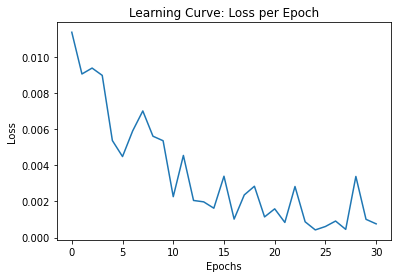

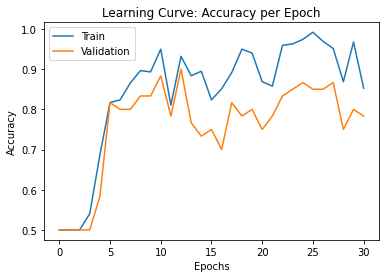

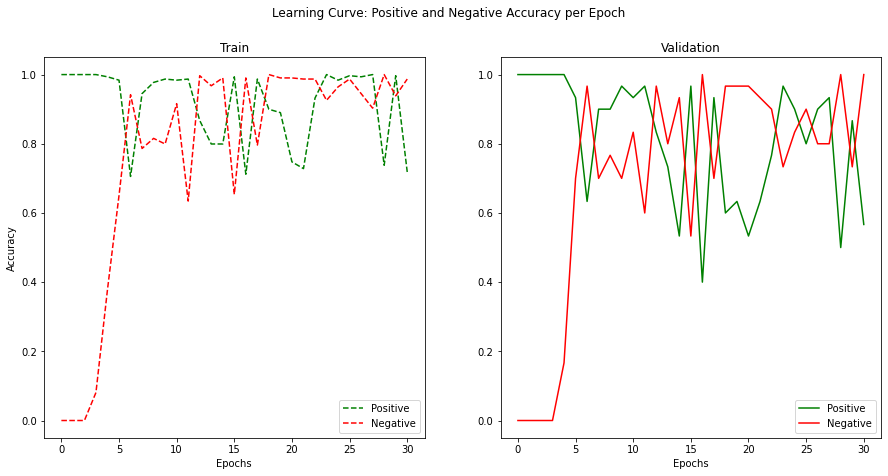

In [ ]:
### hyperparameter change: weight_decay HIGH  = 1e-6
run_model_training(max_epoch = 31,
                  n = 6,
                  krn = 3,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.001,
                  weight_decay = 1e-6,
                  mdl = 'CNNChannel',
                  save_model = False)

Hyperparameter change: kernal size and n of CNNChannel HIGH = 5, 10

Traning...
Epoch 0, Val: [Acc 50% | Pos 100% | Neg 0%] Train: [Acc 50% | Pos 100% | Neg 0% | Loss 0.008664]
Epoch 1, Val: [Acc 60% | Pos 93% | Neg 27%] Train: [Acc 67% | Pos 96% | Neg 39% | Loss 0.008994]
Epoch 2, Val: [Acc 85% | Pos 90% | Neg 80%] Train: [Acc 86% | Pos 86% | Neg 85% | Loss 0.010499]
Epoch 3, Val: [Acc 77% | Pos 97% | Neg 57%] Train: [Acc 81% | Pos 87% | Neg 75% | Loss 0.008499]
Epoch 4, Val: [Acc 73% | Pos 50% | Neg 97%] Train: [Acc 73% | Pos 51% | Neg 96% | Loss 0.004450]
Epoch 5, Val: [Acc 80% | Pos 70% | Neg 90%] Train: [Acc 82% | Pos 71% | Neg 94% | Loss 0.006155]
Epoch 6, Val: [Acc 70% | Pos 47% | Neg 93%] Train: [Acc 72% | Pos 48% | Neg 97% | Loss 0.006174]
Epoch 7, Val: [Acc 73% | Pos 93% | Neg 53%] Train: [Acc 83% | Pos 95% | Neg 70% | Loss 0.007876]
Epoch 8, Val: [Acc 88% | Pos 87% | Neg 90%] Train: [Acc 86% | Pos 85% | Neg 87% | Loss 0.004806]
Epoch 9, Val: [Acc 83% | Pos 97% | Neg 70%] Train: [Acc 89% | Pos 97% | Neg 81% | Loss 0.004018]
Epoch 10, Val: [Acc

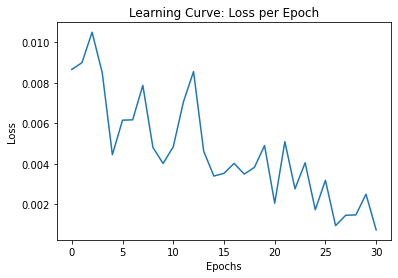

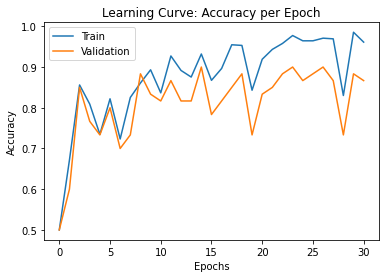

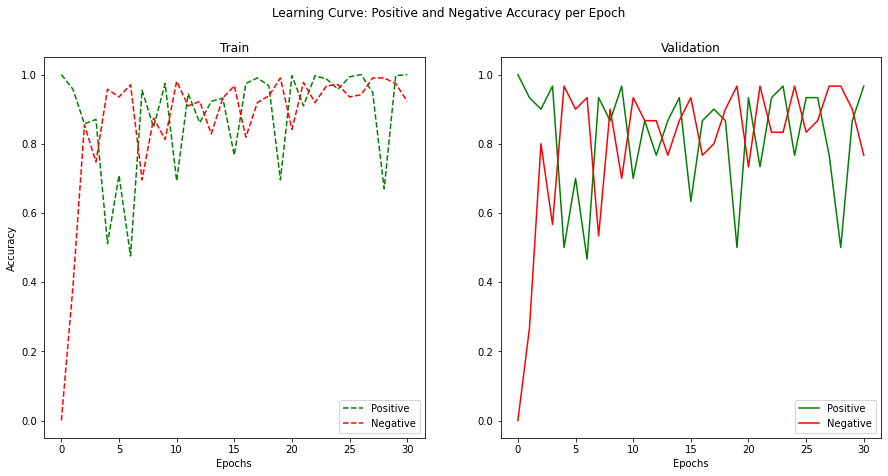

In [ ]:
### hyperparameter change: kernal size and n of CNNChannel HIGH = 5, 10
run_model_training(max_epoch = 31,
                  n = 10,
                  krn = 5,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 50,
                  learning_rate = 0.001,
                  weight_decay = 1e-9,
                  mdl = 'CNNChannel',
                  save_model = False)

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

Final Model

Traning...
Epoch 0, Val: [Acc 57% | Pos 53% | Neg 60%] Train: [Acc 56% | Pos 49% | Neg 64% | Loss 0.047646]
Epoch 1, Val: [Acc 60% | Pos 27% | Neg 93%] Train: [Acc 62% | Pos 38% | Neg 86% | Loss 0.044435]
Epoch 2, Val: [Acc 68% | Pos 50% | Neg 87%] Train: [Acc 67% | Pos 39% | Neg 94% | Loss 0.052363]
Epoch 3, Val: [Acc 73% | Pos 93% | Neg 53%] Train: [Acc 80% | Pos 96% | Neg 64% | Loss 0.027334]
Epoch 4, Val: [Acc 65% | Pos 37% | Neg 93%] Train: [Acc 69% | Pos 40% | Neg 97% | Loss 0.010909]
Epoch 5, Val: [Acc 73% | Pos 100% | Neg 47%] Train: [Acc 80% | Pos 97% | Neg 62% | Loss 0.022886]
Epoch 6, Val: [Acc 85% | Pos 83% | Neg 87%] Train: [Acc 88% | Pos 87% | Neg 88% | Loss 0.035294]
Epoch 7, Val: [Acc 83% | Pos 93% | Neg 73%] Train: [Acc 87% | Pos 90% | Neg 84% | Loss 0.021570]
Epoch 8, Val: [Acc 83% | Pos 80% | Neg 87%] Train: [Acc 86% | Pos 75% | Neg 96% | Loss 0.022099]
Epoch 9, Val: [Acc 88% | Pos 93% | Neg 83%] Train: [Acc 89% | Pos 95% | Neg 84% | Loss 0.016598]
Epoch 10, Val: [Ac

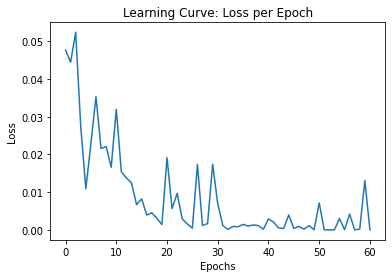

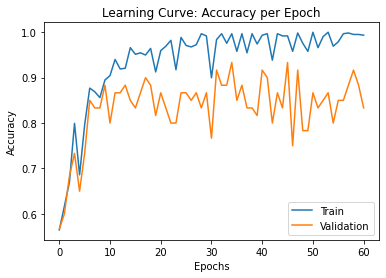

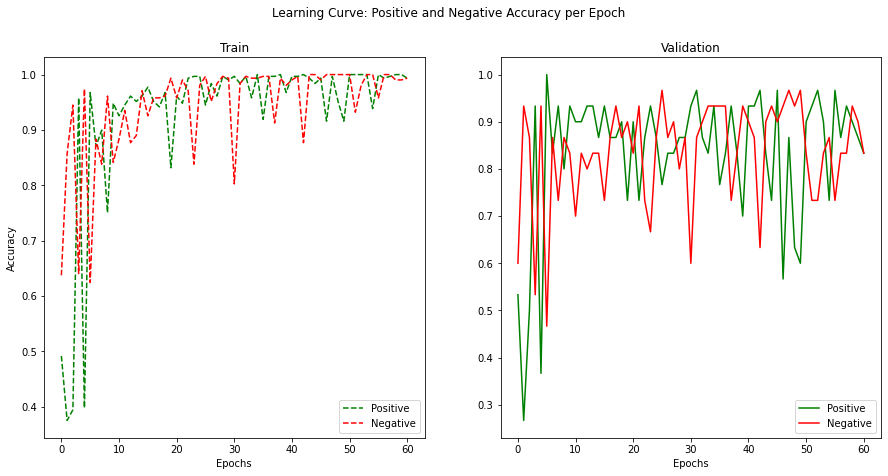

In [ ]:
### Final Model
run_model_training(max_epoch = 61,
                  n = 10,
                  krn = 5,
                  td = train_data,
                  vd = valid_data,
                  batch_size = 31,
                  learning_rate = 0.001,
                  weight_decay = 1e-9,
                  mdl = 'CNNChannel',
                  save_model = False)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

###**Best Models list:**

**CNN:** 

Epoch 57, Val: [Acc 87% | Pos 97% | Neg 77%] Train: [Acc 95% | Pos 100% | Neg 90% | Loss 0.009893]

**CNNChannel:**

Epoch 40, Val: [Acc 92% | Pos 93% | Neg 90%] Train: [Acc 99% | Pos 100% | Neg 99% | Loss 0.002928]


In [54]:
def conf_matrix(pos_acc,neg_acc,amount,title=''):

  #TP = round(pos_acc, 2)*100
  #NP = round(1-pos_acc, 2)*100
  #TF = round(neg_acc, 2)*100
  #NF = round(1-neg_acc, 2)*100

  TP = round(pos_acc*100)
  FP = round(100-TP)
  TN = round(neg_acc*100)
  FN = round(100-TN)

  confusion_per = np.r_[np.c_[TP,FP],
                        np.c_[TN,FN]]
  

  TP_n = round(pos_acc * amount)
  FP_n = round((1-pos_acc) * amount)
  TN_n = round(neg_acc * amount)
  FN_n = round((1-neg_acc) * amount)

  confusion_n = np.r_[np.c_[TP_n,FP_n],
                      np.c_[TN_n,FN_n]]
  
  
  plt.figure()
  plt.matshow(confusion_per, cmap=plt.cm.Blues)
  plt.title('Confusion matrix ' + str(title))
  #plt.colorbar()

  # Add text
  for i in range(0,2):
    for j in range(0,2):
      plt.text(j, i, str(confusion_per[i][j])+'% \n('+ str(confusion_n[i][j]) + ')',
               ha="center", va="center", color="k", size='xx-large')

  plt.xticks(np.arange(2),['True', 'False'])
  plt.yticks(np.arange(2), ['Positive', 'Negative'])

In [21]:
### Load model of best CNN
batch_size=50
model_CNN = CNN(n=6, krn=7) 
model_CNN.load_state_dict(torch.load(main_path+'/models/BestModels/CNN_V5/epoch-57.pk'))

<All keys matched successfully>

Valid: [Acc 87% | Pos 97% | Neg 77%]
Test Men: [Acc 78% | Pos 97% | Neg 60%]
Test Women: [Acc 82% | Pos 97% | Neg 67%]


<Figure size 432x288 with 0 Axes>

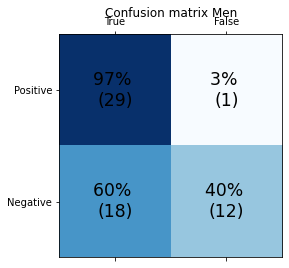

<Figure size 432x288 with 0 Axes>

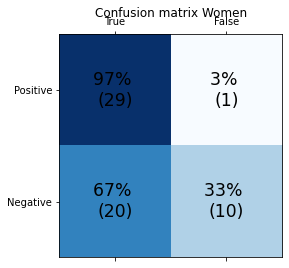

In [55]:
# Valid
pos_acc, neg_acc, acc= get_accuracy(model_CNN, valid_data, batch_size=50)

print("Valid: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc * 100, pos_acc * 100, neg_acc * 100))

# Men test
pos_acc_m, neg_acc_m, acc_m = get_accuracy(model_CNN, test_m, batch_size=50)

print("Test Men: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc_m * 100, pos_acc_m * 100, neg_acc_m * 100))

# Woman test
pos_acc_w, neg_acc_w, acc_w = get_accuracy(model_CNN, test_w, batch_size=50)

print("Test Women: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc_w * 100, pos_acc_w * 100, neg_acc_w * 100))

num_of_pairs_m = test_m.shape[0]*test_m.shape[1]
num_of_pairs_w = test_w.shape[0]*test_w.shape[1]

conf_matrix(pos_acc_m, neg_acc_m, amount=num_of_pairs_m, title='Men')

conf_matrix(pos_acc_w,neg_acc_w, amount=num_of_pairs_w, title='Women')

In [56]:
### Load best model of CNNChannel
model_CNNChannel = CNNChannel(n=10, krn=5) 
model_CNNChannel.load_state_dict(torch.load(main_path+'/models/BestModels/CNNChannle_V2/epoch-40.pk'))

<All keys matched successfully>

Valid: [Acc 90% | Pos 93% | Neg 87%]
Test Men: [Acc 85% | Pos 80% | Neg 90%]
Test Women: [Acc 87% | Pos 83% | Neg 90%]


<Figure size 432x288 with 0 Axes>

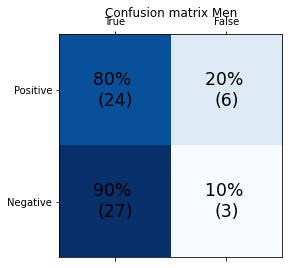

<Figure size 432x288 with 0 Axes>

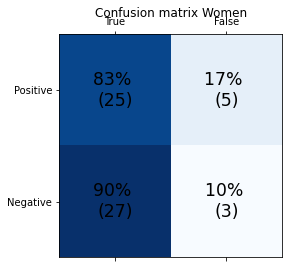

In [59]:
# Valid
pos_acc, neg_acc, acc= get_accuracy(model_CNNChannel, valid_data, batch_size=50)

print("Valid: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc * 100, pos_acc * 100, neg_acc * 100))

# Men test
pos_acc_m, neg_acc_m, acc_m = get_accuracy(model_CNNChannel, test_m, batch_size=50)

print("Test Men: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc_m * 100, pos_acc_m * 100, neg_acc_m * 100))

# Woman test
pos_acc_w, neg_acc_w, acc_w = get_accuracy(model_CNNChannel, test_w, batch_size=50)

print("Test Women: [Acc %.0f%% | Pos %.0f%% | Neg %.0f%%]" % (
      acc_w * 100, pos_acc_w * 100, neg_acc_w * 100))

conf_matrix(pos_acc_m, neg_acc_m, amount=num_of_pairs_m, title='Men')

conf_matrix(pos_acc_w,neg_acc_w, amount=num_of_pairs_w, title='Women')

### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.



In [60]:
def show_model_results(model, input_test,same, currect , onlyone = True):
  # This function find and print results from the model:
  #   for True positive set   : same = True, currect = True (defulet)
  #   for False positive set  : same = True, currect = False 
  #   for True negative set   : same = False, currect = True 
  #   for False negative set  : same = False, currect = False 
  # For printing one result only set onlyone = True, for all results set onlyone = False
  if same:
    data_pairs = generate_same_pair(input_test)
  else:
    data_pairs = generate_different_pair(input_test) 

  for i in range(0, len(data_pairs), batch_size):
    xs = torch.Tensor(data_pairs[i:i+batch_size]).transpose(1, 3)
    if model == 'CNN':
      zs = model_CNN(xs)
    elif model == 'CNNChannel':
      zs = model_CNNChannel(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()

  for idx, lbl in enumerate(pred):
      #  True positive
      if same & currect & lbl == 1:
          plt.figure()
          plt.imshow(data_pairs[idx,:,:,:]+0.5) 
          plt.title('Pair that the model correctly classified')
          if onlyone: return
      # False positive
      if same & (not currect) & (lbl == 0):
          plt.figure()
          plt.imshow(data_pairs[idx,:,:,:]+0.5) 
          plt.title('Pair that the model uncorrectly classified')
          if onlyone: return
      # True negative
      if (not same) & currect & (lbl == 0):
          plt.figure()
          plt.imshow(data_pairs[idx,:,:,:]+0.5) 
          plt.title('Not pair that the model correctly classified')
          if onlyone: return
      # False negative
      if (not same) & (not currect) & (lbl == 1):
          plt.figure()
          plt.imshow(data_pairs[idx,:,:,:]+0.5) 
          plt.title('Not pair that the model uncorrectly classified')
          if onlyone: return

CNN best model (men)

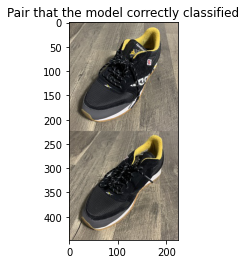

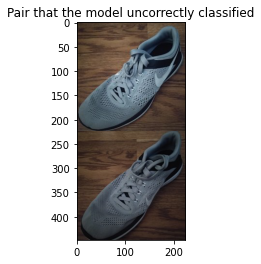

In [61]:
## CNN best model
# men's shoes (pair) that the model correctly classified
show_model_results('CNN', test_m,same = True, currect = True, onlyone = True)

# men's shoes (pair) that the model uncorrectly classified
show_model_results('CNN',test_m,same = True, currect = False, onlyone = True)

CNNChannel best model (men)

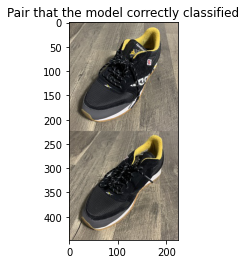

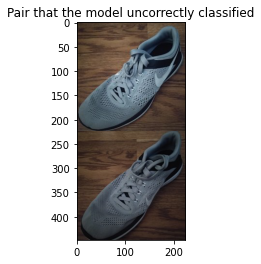

In [62]:
## CNNChannel best model
#  men's shoes (pair) that the model correctly classified - True Positive
show_model_results('CNNChannel', test_m,same = True, currect = True, onlyone = True)

# men's shoes (pair) that the model uncorrectly classified - False Positive
show_model_results('CNNChannel',test_m,same = True, currect = False, onlyone = True)


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

CNN best model (women)

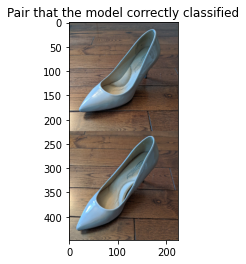

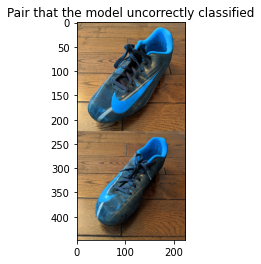

In [63]:
## CNN best model
#  women's shoes (pair) that the model correctly classified - True Positive
show_model_results('CNN', test_w,same = True, currect = True, onlyone = True)

# women's shoes (pair) that the model uncorrectly classified - False Positive
show_model_results('CNN',test_w,same = True, currect = False, onlyone = True)

CNNChannel best model (women)

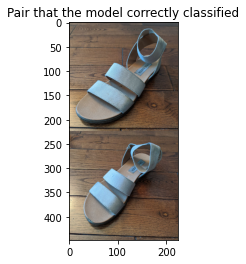

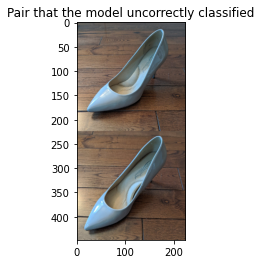

In [64]:
## CNNChannel best model
# women's shoes (pair) that the model correctly classified
show_model_results('CNNChannel', test_w,same = True, currect = True, onlyone = True)

# women's shoes (pair) that the model uncorrectly classified
show_model_results('CNNChannel',test_w,same = True, currect = False, onlyone = True)

In [5]:
# This part used to save this notebook as PDF.
%cd /content/gdrive/MyDrive/Intro_to_Deep_Learning/HW3/
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf Assignment3.ipynb &> /dev/null

/content/gdrive/MyDrive/Intro_to_Deep_Learning/HW3
